In [1]:
## GTI770 - TP1

In [1]:
%matplotlib inline   
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import graphviz
import decimal
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from mdlp.discretization import MDLP
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Get some images
fid = open('GTI770_label_data_set.csv', 'r') 
next(fid) # skip les headers (la premiere ligne)

classDict = {}
imgNb = 1200
X = np.zeros((imgNb, 3, 424, 424), dtype=int)
Y = np.zeros((imgNb, 2), dtype=object)

count = 0
for line in fid:
    element = line.rstrip('\n').split(',')
    
    if element[1] not in classDict:
        classDict[element[1]] = 0     
    elif element[1] in classDict and classDict[element[1]] < imgNb/2:
        classDict[element[1]] += 1;
    else:
        continue
    
    imagePath = 'images/' + element[0] + '.jpg'
    if not os.path.exists(imagePath):
        classDict[element[1]] -= 1    # S'assure d'avoir des images qui existe
        continue
        
    img = cv2.imread(imagePath).reshape(3,424,424)
    img = img[:, :, ::-1]
    
    X[count] = img
    Y[count] = [count, element[1]]
    
    count += 1
    if count >= imgNb:
        break

fid.close() 

In [4]:
def GenerateRandomNumbersList(ArangeLength, GeneratedSetLength):
    a = np.arange(ArangeLength)
    np.random.shuffle(a)
    randomSet = a[:GeneratedSetLength]
    return randomSet

rand1 = GenerateRandomNumbersList(imgNb/2, 10)
rand2 = GenerateRandomNumbersList(imgNb/2, 10)

YSorted = Y[Y[:,1].argsort()]
listSmooth = YSorted[:len(YSorted)//2]
listSpiral = YSorted[len(YSorted)//2:]

In [5]:
train_prop = 0.7
trainNb = int((imgNb * train_prop)/2)

# Étant donné que validation n'est pas nécessaire pour ce laboratoire,
# il contient les mêmes données que test
#test_prop = (1 - train_prop) / 2
#val_prop = (1 - train_prop) / 2
test_prop = (1 - train_prop) 
val_prop = (1 - train_prop) 

valNb = int((imgNb * val_prop) / 2)
testNb = int((imgNb * test_prop) / 2)


Y_train = np.concatenate((listSmooth[:trainNb], listSpiral[:trainNb]), axis=0)
Y_val = np.concatenate((listSmooth[trainNb:trainNb+valNb], listSpiral[trainNb:trainNb+valNb]), axis=0)
Y_test = np.concatenate((listSmooth[-testNb:], listSpiral[-testNb:]), axis=0)

def GenerateXFromY(listY):
    listX = np.zeros((len(listY), 3, 424, 424), dtype=int)
    for i in range(len(listY)):
        imageIndex = listY[i]
        listX[i] = X[imageIndex[0]]
    return listX

X_train = GenerateXFromY(Y_train)
X_val = GenerateXFromY(Y_val)
X_test = GenerateXFromY(Y_test)

#----------------------
#For debug :
# print(len(Y_train))
# print(Y_train)
# print(len(Y_test))
# print(Y_test)
# print(len(X_train))
# print(len(X_test))
#----------------------

In [6]:
def crop(img,cropx,cropy):
    x,y,rgb = img.shape #Prend les valeurs de l'image
    startx = x//2-(cropx//2) #Trouve la nouvelle coordonnée startx
    starty = y//2-(cropy//2) #Trouve la nouvelle coordonnée starty
    return img[startx:startx+cropx,starty:starty+cropy] #Réajuste l'image selon les nouvelle coordonnée et la longueur du crop

X_train_crop = np.zeros((len(X_train), 3, 50, 50), dtype=np.uint8)
X_val_crop = np.zeros((len(X_val), 3, 50, 50), dtype=np.uint8)
X_test_crop = np.zeros((len(X_test), 3, 50, 50), dtype=np.uint8)
for i in range(0, len(X_train)):
    X_train_crop[i] = crop(X_train[i].reshape(424, 424, 3),50,50).reshape(3, 50, 50)
    
for i in range(0, len(X_val)):
    X_val_crop[i] = crop(X_val[i].reshape(424, 424, 3),50,50).reshape(3, 50, 50)
    
for i in range(0, len(X_test)):
    X_test_crop[i] = crop(X_test[i].reshape(424, 424, 3),50,50).reshape(3, 50, 50)
    
#-----------------------
#For Debug :
# print(len(X_train_crop))
# print(len(X_train_crop[0][0]))
# print(len(X_train_crop[0][0][0]))
#-----------------------    

In [7]:
def RgbToGray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]) #Transforme l'image couleur en grayscale

def ToBinaryImage(array):
    binary = np.zeros((len(array), 50, 50), dtype=float)
    for i in range(0, len(array)):
        grayscale = RgbToGray(array[i].reshape(50,50,3))
        thresh_img = np.where(grayscale>128, 255, 0)
        binary[i] = thresh_img
    return binary

X_train_binary = ToBinaryImage(X_train_crop)
X_val_binary = ToBinaryImage(X_val_crop)
X_test_binary = ToBinaryImage(X_test_crop)

#-------------------------------------------
#For debug :
#plt.imshow(X_train_binary[45], cmap=plt.cm.gray)
#plt.imshow(X_train_crop[52].reshape(50,50,3))
#-------------------------------------------

In [8]:
#separate color channels

X_train_crop_red = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_green = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_blue_high = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_blue_mid = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_yellow = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_val_crop_blue_mid = np.zeros((len(X_val_crop),50, 50), dtype=int)
X_test_crop_blue_mid = np.zeros((len(X_test_crop),50, 50), dtype=int)


def ShowColorComparison(imgIndex):
    img = X_train[imgIndex].reshape(424,424,3)
    img_cropped = np.zeros((50, 50, 3), dtype=int)
    img_cropped =  X_train_crop[imgIndex].reshape(50,50,3)
    f, axarr = plt.subplots(1, 7, figsize=(20,20))
    axarr[0].imshow(img)
    axarr[1].imshow(img_cropped)
    
    img_red = np.zeros((50, 50, 1), dtype=int)
    img_green = np.zeros((50, 50, 1), dtype=int)
    img_blue_high = np.zeros((50, 50, 1), dtype=int)
    img_blue_mid = np.zeros((50, 50, 1), dtype=int)
    img_red, img_green, img_blue_high, img_blue_mid = SplitColors(img_cropped)
    
    axarr[2].imshow(img_red, cmap=plt.cm.Reds)
    axarr[3].imshow(img_green, cmap=plt.cm.Greens)
    axarr[4].imshow(img_blue, cmap=plt.cm.Blues)
    axarr[5].imshow(X_train_binary[imgIndex], cmap=plt.cm.gray)
    axarr[6].imshow(img_blue2, cmap=plt.cm.gray)
    plt.show()
    
def SplitRgb(rgb, th_red, th_green, th_blue):
    red = rgb[:, :, 0] > th_red
    green = rgb[:, :, 1] > th_green
    blue = rgb[:, :, 2] > th_blue
    return red, green, blue

def AvgYellow(rgb, th_yel):
    yellow = rgb[:, :, 0]+rgb[:, :, 1]/2 > th_yel
    return yellow

def ShowAll():
    for i in range(0, len(X_train)):
        print("%d- %s" %(i, Y_train[i][1]))
        ShowColorComparison(i)
        
def SplitColors(img_cropped):
    img_red = np.zeros((50, 50, 1), dtype=int)
    img_green = np.zeros((50, 50, 1), dtype=int)
    img_blue_high = np.zeros((50, 50, 1), dtype=int)
    img_blue_mid = np.zeros((50, 50, 1), dtype=int)
    img_yellow = np.zeros((50, 50, 1), dtype=int)
    img_red, img_green, img_blue_high = SplitRgb(img_cropped, 200, 160, 160)
    img_blue_mid = np.where(img_cropped[:,:,2]>90, 255, 0)
    img_yellow = AvgYellow(img_cropped, 160)
    return img_red, img_green, img_blue_high, img_blue_mid, img_yellow

def SplitAllImagesColors():
    img_red = np.zeros((50, 50, 1), dtype=int)
    img_green = np.zeros((50, 50, 1), dtype=int)
    img_blue_high = np.zeros((50, 50, 1), dtype=int)
    img_blue_mid = np.zeros((50, 50, 1), dtype=int)
    img_yellow = np.zeros((50, 50, 1), dtype=int)
    
    for i in range(0, len(X_train_crop)):
        img_red, img_green, img_blue_high, img_blue_mid, img_yellow = SplitColors(X_train_crop[i].reshape(50,50,3))
        X_train_crop_red[i] = img_red
        X_train_crop_green[i] = img_green
        X_train_crop_blue_high[i] = img_blue_high
        X_train_crop_blue_mid[i] = img_blue_mid
        X_train_crop_yellow[i] = img_yellow
    for i in range(0, len(X_val_crop)):
        img_red, img_green, img_blue_high, img_blue_mid, img_yellow = SplitColors(X_val_crop[i].reshape(50,50,3))
        X_val_crop_blue_mid[i] = img_blue_mid
    for i in range(0, len(X_test_crop)):
        img_red, img_green, img_blue_high, img_blue_mid, img_yellow = SplitColors(X_test_crop[i].reshape(50,50,3))
        X_test_crop_blue_mid[i] = img_blue_mid

SplitAllImagesColors()

#-------------------------------------------
#For debug :
# ShowAll()

#print(len(X_train_crop_green))
#print(len(X_train_crop_blue_high))
#print(len(X_train_crop_blue_mid))
#-------------------------------------------

In [9]:
#Extraction de primitive
def TracePlot(array, titre, titre_x, titre_y):        
    length_smooth = 0
    length_spiral = 0

    for element in Y_train :
        if element[1] == "smooth" :
            length_smooth += 1
        elif element[1] == "spiral" :
            length_spiral += 1
            
    X_coord_smooth = np.zeros(length_smooth, dtype=float)
    Y_coord_smooth = np.zeros(length_smooth, dtype=float)
    X_coord_spiral= np.zeros(length_spiral, dtype=float)
    Y_coord_spiral = np.zeros(length_spiral, dtype=float)

    count_smooth = 0
    count_spiral = 0
    for i in range(0, len(X_train)):
        if Y_train[i][1] == "smooth" :
            X_coord_smooth[count_smooth] = array[i][0]
            Y_coord_smooth[count_smooth] = array[i][1]
            count_smooth += 1
        elif Y_train[i][1] == "spiral" :
            X_coord_spiral[count_spiral] = array[i][0]
            Y_coord_spiral[count_spiral] = array[i][1]
            count_spiral += 1
    
    plt.plot(X_coord_smooth, Y_coord_smooth, 'ro')
    plt.plot(X_coord_spiral, Y_coord_spiral, 'g*')
    plt.xlabel(titre_x)
    plt.ylabel(titre_y)
    plt.title(titre)
    plt.grid(True)
    plt.show()
    
def ExtractNumberOfBlackAndWhitePixels(img_array):
    X_train_plot = np.zeros((len(img_array), 2), dtype=int)
    for i in range(0, len(img_array)): 
        X_train_plot[i][0] = np.sum(img_array[i] == 1) or np.sum(img_array[i] == 255) #Number of white pixels
        X_train_plot[i][1] = np.sum(img_array[i] == 0) #Number of black pixels
    return X_train_plot

#--------------------------------------------------------------------
# For debug :
# X_train_plot = np.zeros((len(X_train), 2), dtype=int)
# for i in range(0, len(X_train)):
#     X_train_plot[i][0] = np.sum(X_train_crop_green[i] == 1) #Number of white pixels
#     X_train_plot[i][1] = np.sum(X_train_crop_green[i] == 0) #Number of black pixels
# print(X_train_plot)
# print(X_train_crop_green[0][0][0])
#TracePlot(ExtractNumberOfBlackAndWhitePixels(X_train_crop_green), 'Nombre de pixels blanches en fonction du nombre de pixels noires dans les images binaires avec seulement le channel vert', 'Nombre de pixels blancs', 'Nombre de pixels noirs')
#TracePlot(ExtractNumberOfBlackAndWhitePixels(X_train_binary), 'Nombre de pixels blanches en fonction du nombre de pixels noires dans les images binaire grayscale', 'Nombre de pixels blancs', 'Nombre de pixels noirs')
#---------------------------------------------------------------------

In [10]:
#Extraction de primitives

def ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(arrayBinary, arrayBlue):
    X_train_plot = np.zeros((len(arrayBinary), 2), dtype=float)
    for i in range(0, len(arrayBinary)): 
        X_train_plot[i][0] = np.sum(arrayBinary[i] == 255)
        X_train_plot[i][1] = np.sum(arrayBlue[i] == 255) #or np.sum(X_train_crop_blue_mid[i] == 255)
    return X_train_plot

def ExtractRatioOfBluePixelsVersusWhitePixelsInGrayscale(arrayBinary, arrayBlue, arrayY):
    X_train_plot = np.zeros((len(arrayBinary), 2), dtype=float)
    for i in range(0, len(arrayBinary)): 
        if arrayY[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif arrayY[i][1] == "spiral" :
            X_train_plot[i][0] = 1
        if np.sum(arrayBinary[i] == 255) == 0 :
            X_train_plot[i][1] = 0
        else :
            X_train_plot[i][1] = np.sum(arrayBlue[i] == 255) / np.sum(arrayBinary[i] == 255)
    return X_train_plot
        
def NumberOfRatioHigherThan(ratio, array):
    totalSmooth = 0
    totalSpiral = 0
    for i in range(0, len(array)):
        if Y_train[i][1] == "smooth" :
            if array[i][1] > ratio :
                totalSmooth += 1
        elif Y_train[i][1] == "spiral" :
            if  array[i][1] > ratio :
                totalSpiral += 1
    return totalSmooth, totalSpiral

def Entropie(p1, p2, t):
    entropie = -(p1/t*np.log2(p1/t))-(p2/t*np.log2(p2/t))
    return entropie

def Gain(p1, p2, t, e1, e2, e3):
    gain = e3 - p1/t*e1 - p2/t*e2
    return gain

#---------------------------------------------------------
#For debug :
#print(Entropie(29, 35, 64))
#print(Entropie(21, 5, 26))
#print(Entropie(8, 30, 38))
#print("Nbr smooth high = %d, Nbr smooth lesser = %d \nNbr spiral = %d, Nbr spiral lesser = %d" %(nbSmooth, nbSmoothLesser, nbSpiral, nbSpiralLesser))
#print(Gain(21, 5, 26, Entropie(21, 5, 26), Entropie(8, 30, 38), Entropie(29, 35, 64)))
#TracePlot(ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#TracePlot(ExtractRatioOfBluePixelsVersusWhitePixelsInGrayscale(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#---------------------------------------------------------

In [11]:
#Extraction de primitives (Selon teintes de jaune... non concluant)
def ExtractNbOfBluePixelsVersusAverageYellow():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        X_train_plot[i][0] = np.sum(X_train_crop_yellow[i] == 1)
        X_train_plot[i][1] = np.sum(X_train_crop_blue_mid[i] == 255) #or np.sum(X_train_crop_blue_mid[i] == 255)
    return X_train_plot

def ExtractRatioBlueVsYellow():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        if Y_train[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif Y_train[i][1] == "spiral" :
            X_train_plot[i][0] = 1
        if np.sum(X_train_crop_yellow[i] == 1) == 0 :
            X_train_plot[i][1] = 0
        else :
            X_train_plot[i][1] = np.sum(X_train_crop_blue_mid[i] == 255) / np.sum(X_train_crop_yellow[i] == 1)
    return X_train_plot

def ExtractRatioYellowVsBlue():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        if Y_train[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif Y_train[i][1] == "spiral" :
            X_train_plot[i][0] = 1
        if np.sum(X_train_crop_blue_mid[i] == 255) == 0 :
            X_train_plot[i][1] = 0
        else :
            X_train_plot[i][1] = np.sum(X_train_crop_yellow[i] == 1) / np.sum(X_train_crop_blue_mid[i] == 255)
    return X_train_plot
#--------------------------------------------------------------------
# For debug :
#TracePlot(ExtractNbOfBluePixelsVersusAverageYellow(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#TracePlot(ExtractRatioBlueVsYellow(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#TracePlot(ExtractRatioYellowVsBlue(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#--------------------------------------------------------------------

In [12]:
#extraction de primitive (ratio longueur/largeur)
def GetStretchRatio(img, threshold):
    
    img = img[...,::-1]
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, grayscale = cv2.threshold(grayscale,threshold,255, cv2.THRESH_BINARY)
    binary, contours, hierarchy = cv2.findContours(grayscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    params = cv2.SimpleBlobDetector_Params()
    params.filterByColor = True
    params.blobColor = 255

    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(img)

    # Trouver le plus gros blob
    mx = (0,0,0)
    mx_area = 0
    ratio = 0.0
    for cont in contours:
        rect = cv2.minAreaRect(cont)
        tempbox = cv2.boxPoints(rect)
        p1 = tempbox[0] - tempbox[1]    # points
        p2 = tempbox[3] - tempbox[0]
        c1 = p1[1]  # coordonnées
        c2 = p2[0]
        area = c1 * c2
        if area > mx_area:
            mx = rect
            mx_area = area
            ratio = min(c1,c2) / max(c1,c2)
    # box = cv2.boxPoints(mx)
    # box = np.int0(box)

    # Pour debug/voir le minRect
    # cv2.drawContours(binary, [box], 0, (255, 0, 0))
    # cv2.imshow("contours", binary)
    # cv2.waitKey(0)

    return ratio

def ExtractRatio(threshold, arrayCrop , arrayY):
    X_train_plot = np.zeros((len(arrayCrop), 2), dtype=float)
    for i in range(0, len(arrayCrop)): 
        if arrayY[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif arrayY[i][1] == "spiral" :
            X_train_plot[i][0] = 1    
        X_train_plot[i][1] = GetStretchRatio(arrayCrop[i].reshape(50,50,3), threshold)
    return X_train_plot

In [13]:
# Stats
def Mean(array):
    count_smooth = 0
    count_spiral = 0
    sum_smooth = 0
    sum_spiral = 0
    for i in range(0, len(array)): 
        if Y_train[i][1] == "smooth" :
            count_smooth += 1
            sum_smooth+= array[i][1]
        elif Y_train[i][1] == "spiral" :
            count_spiral += 1
            sum_spiral+= array[i][1]
    
    print("Mean Smooth: ", sum_smooth/count_smooth)
    print("Mean Spiral: ", sum_spiral/count_spiral)


def Median(array):
    count_smooth = 0
    count_spiral = 0
    med_smooth = 0
    med_spiral = 0
    med = np.round(len(Y_train)/4)
    for i in range(0, len(array)): 
        if Y_train[i][1] == "smooth" :
            count_smooth += 1
            if count_smooth == med:
                med_smooth = array[i][1]
        elif Y_train[i][1] == "spiral" :
            count_spiral += 1
            if count_spiral == med:
                med_smooth = array[i][1]
                
    print("Median Smooth: ", med_smooth)
    print("Median Spiral: ", med_spiral)

#----------------------------------------------
# For debug :
# ratio_arr = ExtractRatio(127)
# Mean(ratio_arr)
# Median(ratio_arr)
# TracePlot(ratio_arr, "Ratio", "", "Ratio")
#----------------------------------------------

In [14]:
# Export Data
# ['ratio longueur/largeur', 'pixels blanches grayscale', 'pixels bleu']

num_features = 3 
num_features += 1
ratioThreshold = 127

ratio_train = ExtractRatio(ratioThreshold, X_train_crop, Y_train) 
whitePixel_train = ExtractNumberOfBlackAndWhitePixels(X_train_binary)
bluePixel_train = ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(X_train_binary, X_train_crop_blue_mid)

ratio_val = ExtractRatio(ratioThreshold, X_val_crop, Y_val) 
whitePixel_val = ExtractNumberOfBlackAndWhitePixels(X_val_binary)
bluePixel_val = ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(X_val_binary, X_val_crop_blue_mid)

ratio_test = ExtractRatio(ratioThreshold, X_test_crop, Y_test) 
whitePixel_test = ExtractNumberOfBlackAndWhitePixels(X_test_binary)
bluePixel_test = ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(X_test_binary, X_test_crop_blue_mid)

def ExportData(arrayY, ratio, whitePixel, bluePixel, name):
    feature_vector = np.zeros((len(arrayY), num_features), dtype=float)
    for i in range(0, len(arrayY)): 
        if arrayY[i][1] == "smooth" :
            feature_vector[i] = [ratio[i][1], whitePixel[i][0], bluePixel[i][1], 0]
        elif arrayY[i][1] == "spiral" :
            feature_vector[i] = [ratio[i][1], whitePixel[i][0], bluePixel[i][1], 1]
    
        print (feature_vector[i]) 

    np.savetxt("galaxy_%s.csv" %name, feature_vector, delimiter=",")

In [15]:
ExportData(Y_train, ratio_train, whitePixel_train, bluePixel_train, "train")
ExportData(Y_val, ratio_val, whitePixel_val, bluePixel_val, "val")
ExportData(Y_test, ratio_test, whitePixel_test, bluePixel_test, "test")

[  0.95804197 599.         608.           0.        ]
[7.38254786e-01 7.91000000e+02 5.61000000e+02 0.00000000e+00]
[  1. 178.  32.   0.]
[  1. 119.   3.   0.]
[7.56097555e-01 1.38100000e+03 3.42000000e+02 0.00000000e+00]
[  0.83999997 675.         396.           0.        ]
[7.35294104e-01 9.69000000e+02 9.61000000e+02 0.00000000e+00]
[9.13043261e-01 1.68300000e+03 1.72200000e+03 0.00000000e+00]
[  1. 151.  48.   0.]
[  0.95238096 637.         264.           0.        ]
[9.77777779e-01 2.04800000e+03 1.92900000e+03 0.00000000e+00]
[  0.89999998 160.          57.           0.        ]
[7.53554404e-01 7.70000000e+02 6.02000000e+02 0.00000000e+00]
[  1. 332.  17.   0.]
[ 0.  9. 53.  0.]
[  0.8888889 162.          3.          0.       ]
[9.59183812e-01 1.40500000e+03 8.21000000e+02 0.00000000e+00]
[  1. 167.  42.   0.]
[8.80952358e-01 1.73200000e+03 1.29900000e+03 0.00000000e+00]
[8.9690733e-01 1.1590000e+03 1.3460000e+03 0.0000000e+00]
[  0.7560975 756.        230.          0.       ]
[6

[  1. 141. 334.   1.]
[5.17241418e-01 2.67000000e+02 2.03200000e+03 1.00000000e+00]
[8.35164666e-01 5.96000000e+02 1.00500000e+03 1.00000000e+00]
[5.97560704e-01 8.85000000e+02 1.47900000e+03 1.00000000e+00]
[  0.59374994 294.         544.           1.        ]
[  0.9375 376.     250.       1.    ]
[9.16666687e-01 2.17000000e+02 2.11500000e+03 1.00000000e+00]
[7.27272749e-01 1.06000000e+02 8.88000000e+02 1.00000000e+00]
[2.85714388e-01 3.76000000e+02 2.23600000e+03 1.00000000e+00]
[5.38461506e-01 6.10000000e+01 9.94000000e+02 1.00000000e+00]
[5.88235438e-01 1.34000000e+02 8.21000000e+02 1.00000000e+00]
[  0.81818193 390.         657.           1.        ]
[  0.90769237 198.         523.           1.        ]
[  1.  29. 260.   1.]
[7.14285731e-01 3.30000000e+01 1.56100000e+03 1.00000000e+00]
[3.10399979e-01 3.83000000e+02 7.82000000e+02 1.00000000e+00]
[4.43965435e-01 5.15000000e+02 1.91300000e+03 1.00000000e+00]
[3.53658468e-01 1.52100000e+03 1.24600000e+03 1.00000000e+00]
[6.30136728e

[8.15789461e-01 1.48400000e+03 1.61900000e+03 0.00000000e+00]
[9.79166687e-01 2.21800000e+03 2.49700000e+03 0.00000000e+00]
[  0.88461536 674.         819.           0.        ]
[  0.92045462 565.         621.           0.        ]
[9.66666639e-01 1.70200000e+03 2.00400000e+03 0.00000000e+00]
[  0.96123981 341.         206.           0.        ]
[  0.9375 424.     102.       0.    ]
[7.5641036e-01 1.3420000e+03 1.2140000e+03 0.0000000e+00]
[  0.75 227.   301.     1.  ]
[5.0000006e-01 8.9500000e+02 7.3600000e+02 1.0000000e+00]
[6.250e-01 5.870e+02 2.079e+03 1.000e+00]
[8.79999995e-01 6.16000000e+02 1.64200000e+03 1.00000000e+00]
[9.16666687e-01 1.92000000e+02 1.35000000e+03 1.00000000e+00]
[  0.875 277.    303.      1.   ]
[5.23809791e-01 3.83000000e+02 1.88200000e+03 1.00000000e+00]
[  0.72000003 297.         234.           1.        ]
[  0.83870977 464.         554.           1.        ]
[7.54098177e-01 1.01000000e+02 1.72000000e+03 1.00000000e+00]
[0.000e+00 2.210e+02 1.122e+03 1.000

[8.23529422e-01 3.15000000e+02 2.15600000e+03 1.00000000e+00]
[1.000e+00 2.066e+03 2.446e+03 1.000e+00]
[7.17607915e-01 8.18000000e+02 2.49300000e+03 1.00000000e+00]
[6.66666687e-01 1.37000000e+02 1.18300000e+03 1.00000000e+00]
[4.69973981e-01 4.32000000e+02 1.94900000e+03 1.00000000e+00]
[  0.66666669 102.          60.           1.        ]
[  0.   0. 481.   1.]
[3.10345024e-01 4.65000000e+02 3.30000000e+02 1.00000000e+00]
[  0.91666669 217.         581.           1.        ]
[  0.875 125.    108.      1.   ]
[4.78346497e-01 6.55000000e+02 1.85800000e+03 1.00000000e+00]
[  0.89830458 249.         163.           1.        ]
[5.32150865e-01 8.96000000e+02 2.24200000e+03 1.00000000e+00]
[9.47712898e-01 5.96000000e+02 1.64400000e+03 1.00000000e+00]
[8.88888896e-01 2.14000000e+02 1.13200000e+03 1.00000000e+00]
[3.65000039e-01 3.26000000e+02 1.21900000e+03 1.00000000e+00]
[5.71428597e-01 2.05000000e+02 1.07300000e+03 1.00000000e+00]
[  0.80952388 220.         216.           1.        ]
[  0

In [16]:
# Import train Data

def ImportTrainData():
    num_features = 3
    
    data_train = np.loadtxt("galaxy_train.csv", delimiter=",")
    X_train_tree  = data_train[:,0:num_features]
    Y_train_tree  = data_train[:,num_features]
    
    data_val = np.loadtxt("galaxy_val.csv", delimiter=",")
    X_val_tree  = data_val[:,0:num_features]
    Y_val_tree  = data_val[:,num_features]
    
    data_test = np.loadtxt("galaxy_test.csv", delimiter=",")
    X_test_tree  = data_test[:,0:num_features]
    Y_test_tree  = data_test[:,num_features]
    
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=6)
    model = model.fit(X_train_tree, Y_train_tree)
    prediction_train = model.predict(X_train_tree)
    prediction_val = model.predict(X_val_tree)
    prediction_test = model.predict(X_test_tree)
    return model, prediction_train, prediction_val, prediction_test, Y_train_tree, Y_val_tree, Y_test_tree

In [17]:
# Export Tree

model, prediction_train, prediction_val, prediction_test, Y_train_tree, Y_val_tree, Y_test_tree = ImportTrainData()

def ShowAccScore(Y_tree, prediction, name):
    print("Accuracy score for %s values = %f" %(name, accuracy_score(Y_tree, prediction)))

def ExportTree():
    dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names = ['ratio longueur/largeur', 'pixels blanches grayscale', 'pixels bleu'],  
                         class_names = ['smooth', 'spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render("Galaxy_data") 
    return graph

#ExportTree()

# TP2

### Mails

In [2]:
# Get some mails
fid = open('spam.csv', 'r') 

nbMails = 500
Filter = np.zeros((nbMails, 58), dtype=object)

count = 0
count_spam = 0
count_mail = 0

for line in fid:
    element = line.rstrip('\n').split(',')
    
    if element[57] == '0' and count_mail < nbMails/2:
        count_mail += 1
    elif element[57] == '1' and count_spam < nbMails/2:
        count_spam += 1
    else:
        continue
    
    Filter[count] = element
    
    count += 1
    if count >= nbMails:
        break

fid.close() 

# ----- For debug -----
#print(count_spam)
#print(count_mail)
#print(count)
#print(Filter)
#----------------------

In [3]:
def SplitVectorData_Holdout(primitives_vector, train_portion):
    
    size = len(primitives_vector)
    subsize = len(primitives_vector[0])
    
    val_portion = (1 - train_portion) / 2
    test_portion = (1 - train_portion) / 2

    nbTrain = int(size * train_portion)
    nbVal = int(size * val_portion)
    nbTest = int(size * test_portion)

    array_train = np.zeros((nbTrain, subsize), dtype=object)
    array_val = np.zeros((nbVal, subsize), dtype=object)
    array_test = np.zeros((nbTest, subsize), dtype=object)

    array_train = primitives_vector[:nbTrain]
    array_val = primitives_vector[nbTrain : nbTrain + nbVal]
    array_test = primitives_vector[-nbTest:]
    return array_train, array_val, array_test

def SplitVectorData_KFold(primitives_vector, k, test_portion):
    
    size = len(primitives_vector)
    subsize = len(primitives_vector[0])
    subsetNb = int(size * (1 - test_portion) / k)
    testNb = int(size * test_portion)
    
    array_kfold_train = np.zeros((k, subsetNb, subsize), dtype=object)
    array_kfold_test = np.zeros((testNb, subsize), dtype=object)
    
    for i in range(0, k):
        if i == 0 :
            array_kfold_train[i] = primitives_vector[i * subsetNb]
        else :
            array_kfold_train[i] = primitives_vector[(i-1) * subsetNb : i * subsetNb]
    
    array_kfold_test = primitives_vector[-testNb:]

    return array_kfold_train, array_kfold_test

#Filter_train, Filter_val, Filter_test = SplitVectorDataTrainValTest(Filter, 0.6)

# ----- For debug -----
#Filter_train, Filter_val, Filter_test = SplitVectorDataTrainValTest(Filter, 0.6)
#print(len(Filter_train))
#print(len(Filter_val))
#print(len(Filter_test))
#print(len(Filter))
#----------------------

In [4]:
def GenerateModelDataFromVector(array_train, array_val, array_test, num_features, chosen_model):
    
    num_features = num_features - 1
    
    data_train = array_train
    X_train  = data_train[:,0:num_features]
    Y_train  = data_train[:,num_features]
    
    data_val = array_val
    X_val = data_val[:,0:num_features]
    Y_val = data_val[:,num_features]
    
    data_test = array_test
    X_test = data_test[:,0:num_features]
    Y_test = data_test[:,num_features]
    
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    return model, prediction_train, prediction_val, prediction_test, Y_train, Y_val, Y_test

def TransformData(array_train, array_val, array_test, num_features, chosen_transformer):
    
    num_features = num_features - 1
    
    data_train = array_train
    X_train  = data_train[:,0:num_features]
    Y_train  = data_train[:,num_features]
    
    data_val = array_val
    X_val  = data_val[:,0:num_features]
    Y_val  = data_val[:,num_features]
    
    data_test = array_test
    X_test  = data_test[:,0:num_features]
    Y_test  = data_test[:,num_features]
    
    transformer_train = chosen_transformer
    transformer_train = transformer_train.fit_transform(X_train, Y_train)
    
    transformer_val = chosen_transformer
    transformer_val = transformer_val.fit_transform(X_val, Y_val)
    
    transformer_test = chosen_transformer
    transformer_test = transformer_test.fit_transform(X_test, Y_test)
    return transformer_train, transformer_val, transformer_test, Y_train, Y_val, Y_test

def GenerateModelDataFromTransform(array_train, array_val, array_test, y_train, y_val, y_test, num_features, chosen_model):
    
    num_features = num_features - 1
    
    X_train  = array_train
    Y_train = y_train
    
    X_val = array_val
    Y_val = y_val
    
    X_test  = array_test
    Y_test = y_test
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    return model, prediction_train, prediction_val, prediction_test, Y_train, Y_val, Y_test

def CreateDecisionTreeModel(depth):
    return tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_leaf=1)

In [5]:
#Filter_model_tree_none, Filter_prediction_train_tree_none, Filter_prediction_val_tree_none, Filter_prediction_test_tree_none, Filter_train_tree_none, Filter_val_tree_none, Filter_test_tree_none = GenerateModelDataFromVector(Filter_train, Filter_val, Filter_test, len(Filter[0]), CreateDecisionTreeModel(None))
#Filter_model_tree_3, Filter_prediction_train_tree_3, Filter_prediction_val_tree_3, Filter_prediction_test_tree_3, Filter_train_tree_3, Filter_val_tree_3, Filter_test_tree_3 = GenerateModelDataFromVector(Filter_train, Filter_val, Filter_test, len(Filter[0]), CreateDecisionTreeModel(3))
#Filter_model_tree_5, Filter_prediction_train_tree_5, Filter_prediction_val_tree_5, Filter_prediction_test_tree_5, Filter_train_tree_5, Filter_val_tree_5, Filter_test_tree_5 = GenerateModelDataFromVector(Filter_train, Filter_val, Filter_test, len(Filter[0]), CreateDecisionTreeModel(5))
#Filter_model_tree_10, Filter_prediction_train_tree_10, Filter_prediction_val_tree_10, Filter_prediction_test_tree_10, Filter_train_tree_10, Filter_val_tree_10, Filter_test_tree_10 = GenerateModelDataFromVector(Filter_train, Filter_val, Filter_test, len(Filter[0]), CreateDecisionTreeModel(10))

def ExportTree(model):
    dot_data = tree.export_graphviz(model, out_file=None, 
                         #feature_names = ['', '', ''],  
                         class_names = ['spam', 'mail'],
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render("Filter_data") 
    return graph

def GenerateScores(array):
    AccScores = np.zeros(len(array), dtype=float)
    F1Scores = np.zeros(len(array), dtype=float)

    for i in range(0, len(array)):
        AccScores[i] = accuracy_score(array[i][0], array[i][1])
        F1Scores[i] = f1_score(array[i][0], array[i][1], average='weighted')
    
    return AccScores, F1Scores

#Extraction de primitive
def TracePlot(array_acc_X, array_acc_Y, array_f1_X, array_f1_Y, titre, titre_x, titre_y):        
    
    plt.plot(array_acc_X, array_acc_Y, 'ro')
    plt.plot(array_f1_X, array_f1_Y, 'g*')
    plt.xlabel(titre_x)
    plt.ylabel(titre_y)
    plt.title(titre)
    plt.grid(True)
    plt.show()

#array_tree = [[Filter_val_tree_none, Filter_prediction_val_tree_none],
           #[Filter_val_tree_3, Filter_prediction_val_tree_3],
           #[Filter_val_tree_5, Filter_prediction_val_tree_5],
           #[Filter_val_tree_10, Filter_prediction_val_tree_10]]

#Array_AccScores, Array_F1Scores = GenerateScores(array_tree)

#print(Array_AccScores)
#print(Array_F1Scores)

#TracePlot([0, 3, 5, 10], Array_AccScores, [0, 3, 5, 10], Array_F1Scores, "Courbe de l'évolution des scores de précision et f1 selon le maximum de profondeur de l'arbre de décision", "Max_depth", "Score")

In [6]:
def DecisionTree_Holdout(array):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)

    array_model_none, array_prediction_train_none, array_prediction_val_none, array_prediction_test_none, array_train_none, array_val_none, array_test_none = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(None))
    array_model_3, array_prediction_train_3, array_prediction_val_3, array_prediction_test_3, array_train_3, array_val_3, array_test_3 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(3))
    array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(5))
    array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(10))

    validations = [[array_val_none, array_prediction_val_none],
    [array_val_3, array_prediction_val_3],
    [array_val_5, array_prediction_val_5],
    [array_val_10, array_prediction_val_10]]

    return GenerateScores(validations)

In [7]:
def scores_mean(array_scores):
    
    size = len(array_scores)
    subsize = len(array_scores[0])
    array_mean = np.zeros(subsize, dtype=float)
    
    for i in range(0, size):
        for j in range(0, subsize):
            array_mean[j] += array_scores[i][j]
            
    for j in range(0, subsize):
            array_mean[j] = array_mean[j] / size
    
    return array_mean

def concatenateWithoutTestPortion(full_array, index):
    result_array = []
    for i in range(0, len(full_array)):
        if len(result_array) == 0:
            result_array = full_array[i]
        elif i != index :
            result_array = np.concatenate((result_array, full_array[i]), axis=0)
    return result_array

def DecisionTree_KFold(array,k):

    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    all_accScores = np.zeros((k, 4), dtype=float)
    all_f1Scores = np.zeros((k, 4), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test

        array_model_none, array_prediction_train_none, array_prediction_val_none, array_prediction_test_none, array_train_none, array_val_none, array_test_none = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(None))
        array_model_3, array_prediction_train_3, array_prediction_val_3, array_prediction_test_3, array_train_3, array_val_3, array_test_3 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(3))
        array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_tree_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(5))
        array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_tree_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(10))

        validations = [[array_val_none, array_prediction_val_none],
        [array_val_3, array_prediction_val_3],
        [array_val_5, array_prediction_val_5],
        [array_val_10, array_prediction_val_10]]

        Array_AccScores, Array_F1Scores = GenerateScores(validations)

        all_accScores[i] = Array_AccScores
        all_f1Scores[i] = Array_F1Scores

    accScores_mean = scores_mean(all_accScores)
    f1Scores_mean = scores_mean(all_f1Scores)
    
    return accScores_mean, f1Scores_mean

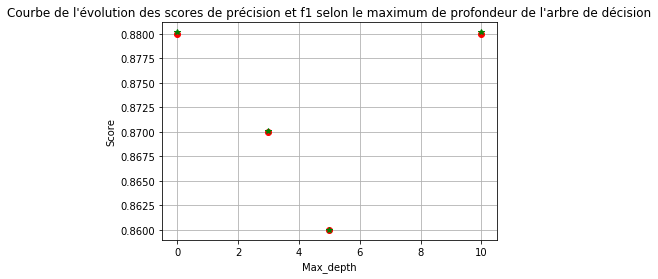

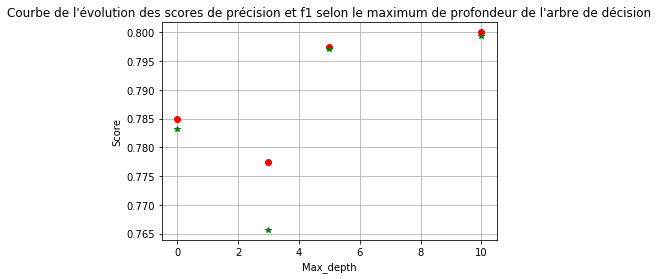

In [8]:
accScores, f1Scores= DecisionTree_Holdout(Filter)
TracePlot([0, 3, 5, 10], accScores, [0, 3, 5, 10], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon le maximum de profondeur de l'arbre de décision", "Max_depth", "Score")
accScores, f1Scores = DecisionTree_KFold(Filter,10)
TracePlot([0, 3, 5, 10], accScores, [0, 3, 5, 10], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon le maximum de profondeur de l'arbre de décision", "Max_depth", "Score")

In [9]:





#----------------------------- For debug --------------------------------
# def ShowAccScore(Y_tree, prediction, name):
#     print("Accuracy score for %s values = %f" %(name, accuracy_score(Y_tree, prediction)))
    
# def ShowF1Score(Y_tree, prediction, name):
#     print("F1 score for %s values = %f" %(name, f1_score(Y_tree, prediction, average='weighted')))
    
# ShowAccScore(Filter_train_tree_none, Filter_prediction_train_tree_none, "train")
# ShowF1Score(Filter_train_tree_none, Filter_prediction_train_tree_none, "train")

# ShowAccScore(Filter_val_tree_none, Filter_prediction_val_tree_none, "validation")
# ShowF1Score(Filter_val_tree_none, Filter_prediction_val_tree_none, "validation")

# ShowAccScore(Filter_test_tree_none, Filter_prediction_test_tree_none, "test")
# ShowF1Score(Filter_test_tree_none, Filter_prediction_test_tree_none, "test")

#ExportTree(Filter_model_tree_none)
#-------------------------------------------------------------------------

In [10]:
def Bayes_Holdout(array):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)

    transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp = TransformData(array_train, array_val, array_test, len(array_train[0]), MDLP())
    transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax = TransformData(array_train, array_val, array_test, len(array_train[0]), MinMaxScaler())

    array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), GaussianNB(priors=[0.4003,0.5997]))
    array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), MultinomialNB(fit_prior=True, class_prior=[0.4003,0.5997]))
    array_model_mdlp, array_prediction_train_mdlp, array_prediction_val_mdlp, array_prediction_test_mdlp, array_train_mdlp, array_val_mdlp, array_test_mdlp = GenerateModelDataFromTransform(transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp, len(array[0]), MultinomialNB())
    array_model_minmax, array_prediction_train_minmax, array_prediction_val_minmax, array_prediction_test_minmax, array_train_minmax, array_val_minmax, array_test_minmax = GenerateModelDataFromTransform(transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax, len(array[0]), MultinomialNB())


    validations = [[array_val_5, array_prediction_val_5],
    [array_val_10, array_prediction_val_10],
    [array_val_mdlp, array_prediction_val_mdlp],
    [array_val_minmax, array_prediction_val_minmax]]

    return GenerateScores(validations)

    
    
def Bayes_KFold(array, k):
    
    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    all_accScores = np.zeros((k, 4), dtype=float)
    all_f1Scores = np.zeros((k, 4), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test

    transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp = TransformData(array_train, array_val, array_test, len(array_train[0]), MDLP())
    transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax = TransformData(array_train, array_val, array_test, len(array_train[0]), MinMaxScaler())

    array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), GaussianNB(priors=[0.4003,0.5997]))
    array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), MultinomialNB(fit_prior=True, class_prior=[0.4003,0.5997]))
    array_model_mdlp, array_prediction_train_mdlp, array_prediction_val_mdlp, array_prediction_test_mdlp, array_train_mdlp, array_val_mdlp, array_test_mdlp = GenerateModelDataFromTransform(transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp, len(array[0]), MultinomialNB())
    array_model_minmax, array_prediction_train_minmax, array_prediction_val_minmax, array_prediction_test_minmax, array_train_minmax, array_val_minmax, array_test_minmax = GenerateModelDataFromTransform(transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax, len(array[0]), MultinomialNB())


    validations = [[array_val_5, array_prediction_val_5],
                 [array_val_10, array_prediction_val_10],
                 [array_val_mdlp, array_prediction_val_mdlp],
                 [array_val_minmax, array_prediction_val_minmax]]

    Array_AccScores, Array_F1Scores = GenerateScores(validations)
        
    all_accScores[i] = Array_AccScores
    all_f1Scores[i] = Array_F1Scores 
        
    accScores_mean = scores_mean(all_accScores)
    f1Scores_mean = scores_mean(all_f1Scores)

    return accScores_mean, f1Scores_mean
    


C:\Anaconda3\envs\gti770\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


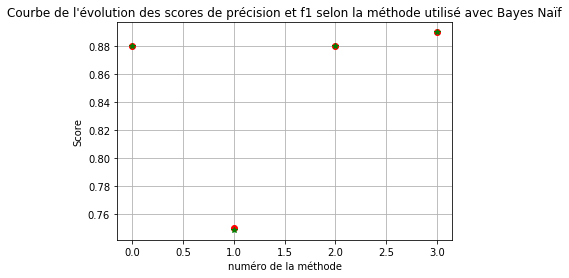

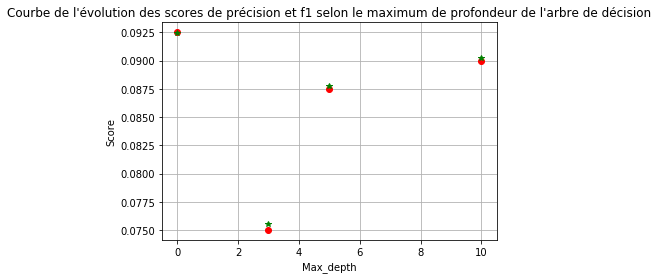

In [11]:
accScores, f1Scores = Bayes_Holdout(Filter)
TracePlot([0, 1, 2, 3], accScores, [0, 1, 2, 3], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon la méthode utilisé avec Bayes Naïf", "numéro de la méthode", "Score")
accScores, f1Scores = Bayes_KFold(Filter, 10)
TracePlot([0, 3, 5, 10], accScores, [0, 3, 5, 10], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon le maximum de profondeur de l'arbre de décision", "Max_depth", "Score")

In [12]:
def CreateKNNModel(k, weight):
    return KNeighborsClassifier(n_neighbors=3, weights=weight)

def KNN_Holdout(array):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)

    array_model_3u, array_prediction_train_3u, array_prediction_val_3u, array_prediction_test_3u, array_train_3u, array_val_3u, array_test_3u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'uniform'))
    array_model_5u, array_prediction_train_5u, array_prediction_val_5u, array_prediction_test_5u, array_train_5u, array_val_5u, array_test_5u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'uniform'))
    array_model_10u, array_prediction_train_10u, array_prediction_val_10u, array_prediction_test_10u, array_train_10u, array_val_10u, array_test_10u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'uniform'))
    array_model_3d, array_prediction_train_3d, array_prediction_val_3d, array_prediction_test_3d, array_train_3d, array_val_3d, array_test_3d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'distance'))
    array_model_5d, array_prediction_train_5d, array_prediction_val_5d, array_prediction_test_5d, array_train_5d, array_val_5d, array_test_5d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'distance'))
    array_model_10d, array_prediction_train_10d, array_prediction_val_10d, array_prediction_test_10d, array_train_10d, array_val_10d, array_test_10d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'distance'))

    validations_uniform = [[array_val_3u, array_prediction_val_3u],
                        [array_val_5u, array_prediction_val_5u],
                        [array_val_10u, array_prediction_val_10u]]

    validations_distance = [[array_val_3d, array_prediction_val_3d],
                        [array_val_5d, array_prediction_val_5d],
                        [array_val_10d, array_prediction_val_10d]]

    accScores_uniform, f1Scores_uniform = GenerateScores(validations_uniform)
    accScores_distance, f1Scores_dsitance = GenerateScores(validations_distance)

    return accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_dsitance
    
def KNN_KFold(array, k):

    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    all_accScores_uniform = np.zeros((k, 3), dtype=float)
    all_f1Scores_uniform = np.zeros((k, 3), dtype=float)
    all_accScores_distance = np.zeros((k, 3), dtype=float)
    all_f1Scores_distance = np.zeros((k, 3), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test

        array_model_3u, array_prediction_train_3u, array_prediction_val_3u, array_prediction_test_3u, array_train_3u, array_val_3u, array_test_3u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'uniform'))
        array_model_5u, array_prediction_train_5u, array_prediction_val_5u, array_prediction_test_5u, array_train_5u, array_val_5u, array_test_5u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'uniform'))
        array_model_10u, array_prediction_train_10u, array_prediction_val_10u, array_prediction_test_10u, array_train_10u, array_val_10u, array_test_10u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'uniform'))
        array_model_3d, array_prediction_train_3d, array_prediction_val_3d, array_prediction_test_3d, array_train_3d, array_val_3d, array_test_3d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'distance'))
        array_model_5d, array_prediction_train_5d, array_prediction_val_5d, array_prediction_test_5d, array_train_5d, array_val_5d, array_test_5d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'distance'))
        array_model_10d, array_prediction_train_10d, array_prediction_val_10d, array_prediction_test_10d, array_train_10d, array_val_10d, array_test_10d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'distance'))

        validations_uniform = [[array_val_3u, array_prediction_val_3u],
        [array_val_5u, array_prediction_val_5u],
        [array_val_10u, array_prediction_val_10u]]

        validations_distance = [[array_val_3d, array_prediction_val_3d],
        [array_val_5d, array_prediction_val_5d],
        [array_val_10d, array_prediction_val_10d]]

        Array_AccScores_uniform, Array_F1Scores_uniform = GenerateScores(validations_uniform)
        Array_AccScores_distance, Array_F1Scores_distance = GenerateScores(validations_distance)

        all_accScores_uniform[i] = Array_AccScores_uniform
        all_f1Scores_uniform[i] = Array_F1Scores_uniform
        all_accScores_distance[i] = Array_AccScores_distance
        all_f1Scores_distance[i] = Array_F1Scores_distance

    accScores_mean_uniform = scores_mean(all_accScores_uniform)
    f1Scores_mean_uniform = scores_mean(all_f1Scores_uniform)
    accScores_mean_distance = scores_mean(all_accScores_distance)
    f1Scores_mean_distance = scores_mean(all_f1Scores_distance)

    return accScores_mean_uniform, f1Scores_mean_uniform, accScores_mean_distance, f1Scores_mean_distance

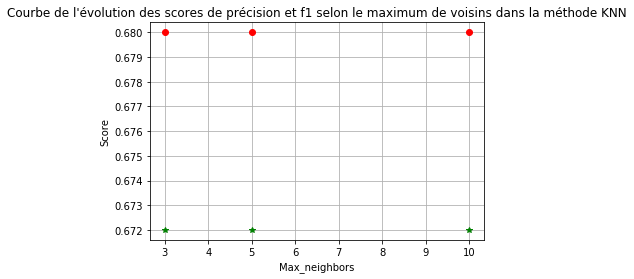

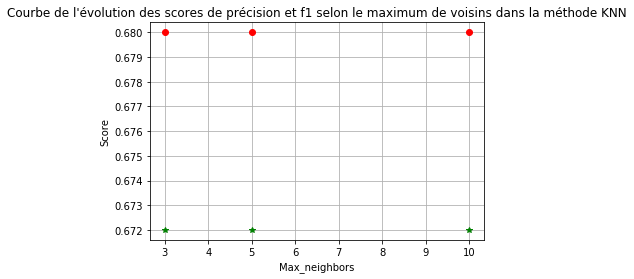

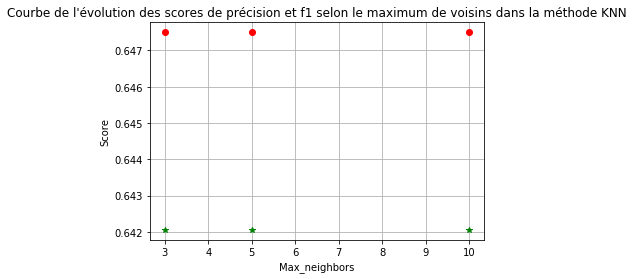

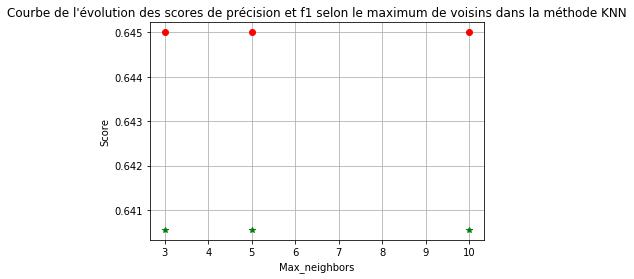

In [13]:
accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_distance = KNN_Holdout(Filter)
TracePlot([3, 5, 10], accScores_uniform, [3, 5, 10], f1Scores_uniform, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN", "Max_neighbors", "Score")
TracePlot([3, 5, 10], accScores_distance, [3, 5, 10], f1Scores_distance, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN", "Max_neighbors", "Score")
    
accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_distance = KNN_KFold(Filter, 10)
TracePlot([3, 5, 10], accScores_uniform, [3, 5, 10], f1Scores_uniform, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN", "Max_neighbors", "Score")
TracePlot([3, 5, 10], accScores_distance, [3, 5, 10], f1Scores_distance, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN", "Max_neighbors", "Score")
    

In [17]:
# Get some images
fid = open('galaxy_feature_vectors.csv', 'r') 

NbGalaxy = 500
Galaxies = np.zeros((NbGalaxy, 76), dtype=object)

count = 0
count_smooth = 0
count_spiral = 0

for line in fid:
    element = line.rstrip('\n').split(',')
    
    label = float(element[75])
    
    if label == 0.0 and count_smooth < NbGalaxy/2:
        count_smooth += 1     
    elif label == 1.0 and count_spiral < NbGalaxy/2:
        count_spiral += 1
    else:
        continue
    
  #  for x in range(0, len(element)):
   #     Galaxies[count][x] = float(decimal.Decimal(element[x]))
    Galaxies[count] = element
    
    
    
    count += 1
    if count >= NbGalaxy:
        break

fid.close() 

# ----- For debug -----
#print(count_smooth)
#print(count_spiral)
#print(count)
print(Galaxies)
#----------------------

[['3.629520000000000000e+05' '4.393092408703673613e+01'
  '5.101459655976992735e+01' ... '-2.648053447730115437e-16'
  '5.576360195985669764e-24' '1.000000000000000000e+00']
 ['8.309560000000000000e+05' '3.851094412660461330e+01'
  '5.007568383001736123e+01' ... '1.372938006137341622e-17'
  '4.810017743074083137e-27' '0.000000000000000000e+00']
 ['7.267330000000000000e+05' '2.819463688972206228e+01'
  '4.363957942782622723e+01' ... '4.756659825490943628e-18'
  '2.006335411793292380e-26' '0.000000000000000000e+00']
 ...
 ['4.923880000000000000e+05' '3.136068125629521219e+01'
  '3.640838751030125309e+01' ... '-4.050587121560198686e-17'
  '4.158314992728260506e-25' '0.000000000000000000e+00']
 ['7.254590000000000000e+05' '4.399676429104787445e+01'
  '5.231651870903509405e+01' ... '3.613215417168231672e-18'
  '3.466218416450970989e-26' '0.000000000000000000e+00']
 ['9.082960000000000000e+05' '3.485463966932247359e+01'
  '4.909659737614568797e+01' ... '1.438440245807894987e-17'
  '-2.387612

In [18]:
accScores, f1Scores = Bayes_Holdout(Galaxies)
TracePlot([0, 1, 2, 3], accScores, [0, 1, 2, 3], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon la méthode utilisé avec Bayes Naïf", "numéro de la méthode", "Score")
accScores, f1Scores = Bayes_KFold(Galaxies, 10)
TracePlot([0, 3, 5, 10], accScores, [0, 3, 5, 10], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon le maximum de profondeur de l'arbre de décision", "Max_depth", "Score")

ValueError: invalid literal for int() with base 10: '1.000000000000000000e+00'

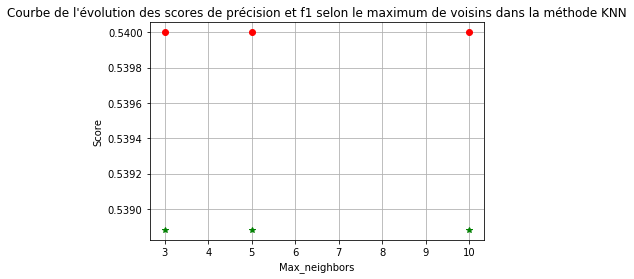

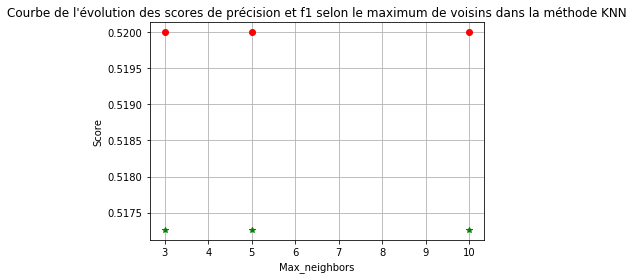

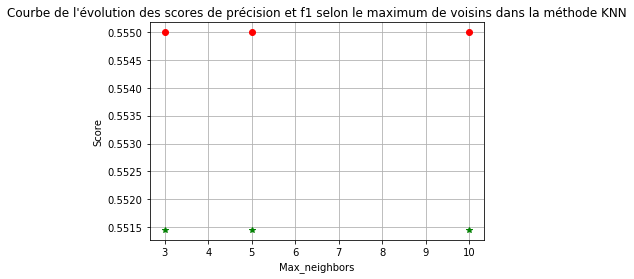

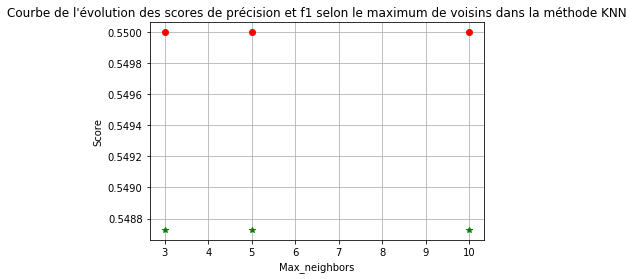

In [19]:
accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_distance = KNN_Holdout(Galaxies)
TracePlot([3, 5, 10], accScores_uniform, [3, 5, 10], f1Scores_uniform, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN", "Max_neighbors", "Score")
TracePlot([3, 5, 10], accScores_distance, [3, 5, 10], f1Scores_distance, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN", "Max_neighbors", "Score")
    
accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_distance = KNN_KFold(Galaxies, 10)
TracePlot([3, 5, 10], accScores_uniform, [3, 5, 10], f1Scores_uniform, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN", "Max_neighbors", "Score")
TracePlot([3, 5, 10], accScores_distance, [3, 5, 10], f1Scores_distance, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN", "Max_neighbors", "Score")
